In [1]:
from init import *
import hytraj as ht
from hytraj import HyData, HyGen, HyReceptor

autotime loaded.
autotime loaded.
black loaded.
black loaded.
time: 1.94 s


<IPython.core.display.Javascript object>

In [2]:
class HyModel(HyReceptor):
    def plot_map(self, pscf, boundinglat=40, axes=[], cmap="jet"):
        if len(axes) == 0:
            fig, ax = plt.subplots(1, 1, figsize=(8, 8))
            cax = fig.add_axes([0.15, 0.06, 0.7, 0.04])
        else:
            fig, ax, cax = axes
        m = Basemap(
            projection="npstere", lon_0=180, boundinglat=boundinglat, round=True, ax=ax
        )
        data, lonx = addcyclic(pscf.T.values, pscf["Longitude"])
        latx, lonx = np.meshgrid(pscf["Latitude"], lonx)
        lonx, latx = m(lonx, latx)
        if pscf.max().values <= 1:
            h = m.contourf(lonx, latx, data.T, levels=np.arange(0, 1.1, 0.1), cmap=cmap)
        else:
            levels = np.arange(0, pscf.max(), 2)
            h = m.contourf(lonx, latx, data.T, levels=levels, cmap=cmap)
        plt.colorbar(h, cax=cax, orientation="horizontal")
        m.drawcoastlines(linewidth=1.5)
        m.drawcountries(linewidth=0.55)
        # ax.set_title(self.station, fontweight="bold")
        return fig, ax, m

time: 3.79 ms


<IPython.core.display.Javascript object>

In [3]:
stations = {
    "Boreal Forest": (70, 108),
    "Coastal Tundra": (71, 155),
    "Central Arctic": (90, 0),
    "Greenland": (72, 320),
}

time: 761 µs


<IPython.core.display.Javascript object>

In [4]:
var = "tcco"
files = glob.glob("data/*.nc")
dx = xr.open_mfdataset(files)  # [var]  # ["aod550"]  # ["tcso2"]  # ["tcco"]
dx = dx.to_array(dim="species")
dx

<xarray.DataArray 'stack-5d1101aee866d6ecf1f912feb7b9fd08' (species: 5, time: 6119, latitude: 34, longitude: 480)>
dask.array<stack, shape=(5, 6119, 34, 480), dtype=float32, chunksize=(1, 3287, 34, 480), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.25 -178.5 ... 177.75 178.5 179.25
  * latitude   (latitude) float32 89.75 89.0 88.25 87.5 ... 66.5 65.75 65.0
  * time       (time) datetime64[ns] 2003-03-01 2003-03-02 ... 2019-11-30
  * species    (species) <U8 'bcaod550' 'duaod550' 'aod550' 'tcco' 'tcso2'
Attributes:
    Conventions:  CF-1.6
    history:      2021-01-03 08:48:02 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

time: 52.2 ms


<IPython.core.display.Javascript object>

In [5]:
data = xr.open_mfdataset("/media/pankaj/Repo/traj/vikash/nc/*.500.ncep_new.nc")
data

<xarray.Dataset>
Dimensions:         (geo: 4, step: 361, time: 7305)
Coordinates:
  * step            (step) int64 0 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360
  * time            (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2019-12-31
  * geo             (geo) object 'lat' 'lon' 'alt' 'pre'
Data variables:
    Boreal Forest   (geo, step, time) float64 dask.array<chunksize=(4, 361, 366), meta=np.ndarray>
    Coastal Tundra  (geo, step, time) float64 dask.array<chunksize=(4, 361, 366), meta=np.ndarray>
    Central Arctic  (geo, step, time) float64 dask.array<chunksize=(4, 361, 366), meta=np.ndarray>
    Greenland       (geo, step, time) float64 dask.array<chunksize=(4, 361, 366), meta=np.ndarray>

time: 226 ms


<IPython.core.display.Javascript object>

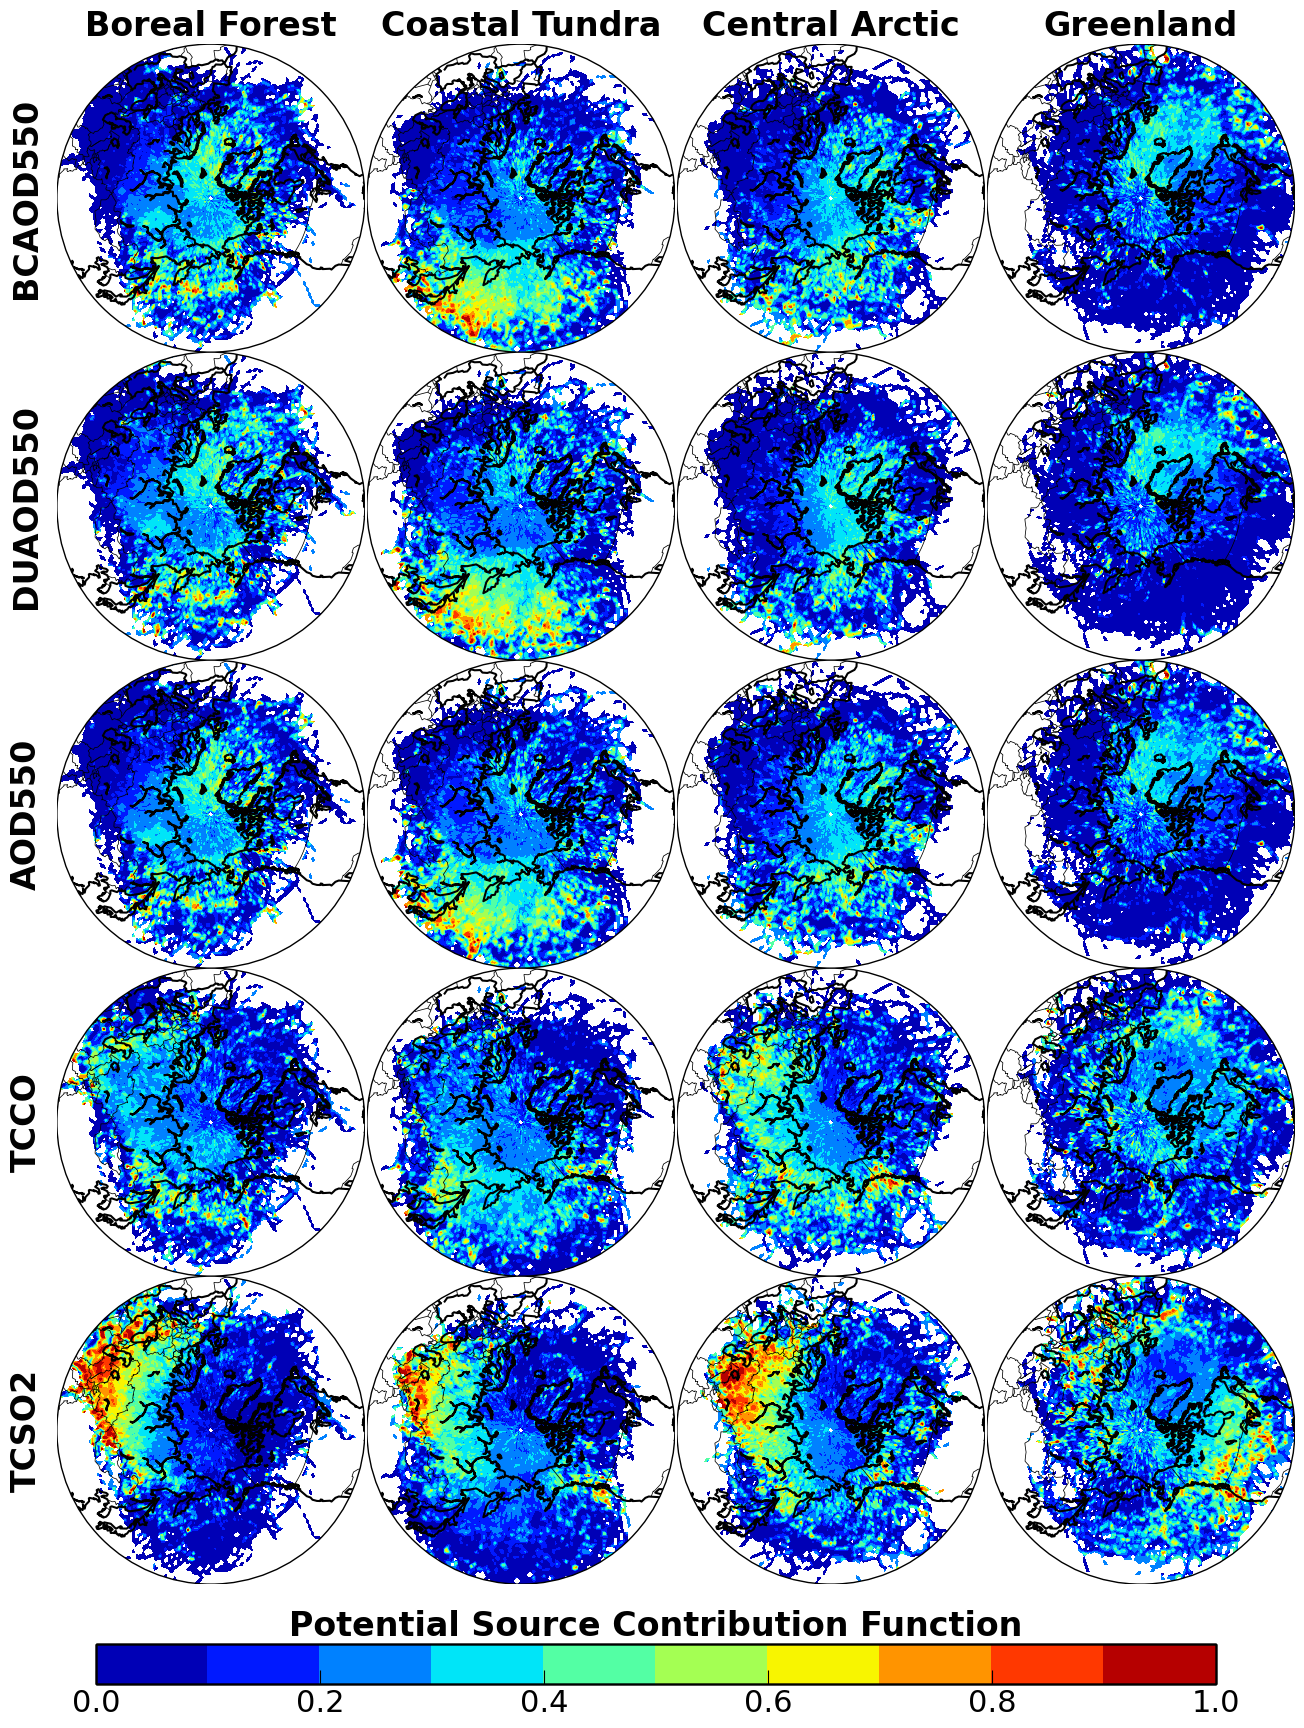

time: 27.6 s


<IPython.core.display.Javascript object>

In [6]:
dates = pd.date_range("2004-01-01", "2019-11-30", freq="D")

fig, axes = plt.subplots(5, 4, figsize=(16, 20))
# axes = axes.flatten()
cax = fig.add_axes([0.15, 0.06, 0.7, 0.02])
cax.set_title("Potential Source Contribution Function", fontweight="bold")

for i, var_name in enumerate(dx.species.values):
    ds = dx.sel(species=var_name)
    df = pd.DataFrame(index=ds.time.values)
    axes[i, 0].set_ylabel(var_name.upper(), fontweight="bold")
    for j, station in enumerate(stations.keys()):
        lat, lon = stations[station]
        df[station] = ds.sel(latitude=lat, longitude=lon, method="nearest")
        if i == 0:
            axes[0, j].set_title(station, fontweight="bold")

    for j, station in enumerate(stations.keys()):
        model = HyModel(
            df.loc[dates, station], data.sel(time=dates), station_name=station
        )
        # cwt = model.calculate_cwt(weighted=False)
        pscf = model.calculate_pscf(thresh=0.75)
        # rtwc = model.calculate_rtwc(normalise=True)

        name = "_".join(station.split(" "))
        model.plot_map(pscf, boundinglat=30, axes=[fig, axes[i, j], cax])
        # plt.savefig(filename, bbox_inches="tight")
plt.subplots_adjust(hspace=0, wspace=0)

filename = "./figs/%s_%s_pscf.png" % (
    dates[0].year,
    dates[-1].year,
)
plt.savefig(filename, bbox_inches="tight")
plt.show()

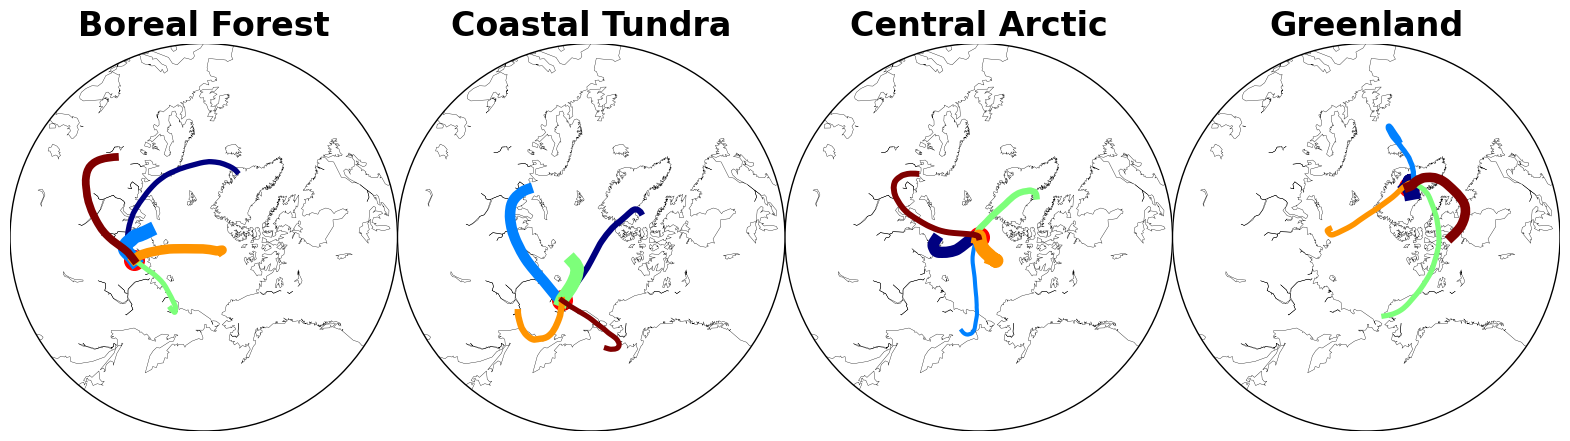

time: 1min 7s


<IPython.core.display.Javascript object>

In [7]:
n_clusters = 5

fig, axes = plt.subplots(1, 4, figsize=(20, 6))
axes = axes.flatten()
for j, (station, ax) in enumerate(zip(stations.keys(), axes)):
    dff = data[station].dropna(dim="time").sel(time=slice("2004-01-01", "2019-11-30"))
    m = Basemap(projection="npstere", lon_0=180, boundinglat=40, round=True, ax=ax)
    # labels = ht.HyCluster(dff, projection=m).fit(kmax=20, method="KMeans", pyclus=False)
    labels = ht.HyCluster(dff, projection=m).get_kmeans_cluster(n_clusters)
    trj = ht.ClusterPlot(dff, labels, m)
    trj.plot_representative_trajectories(lw=30)
    m.drawcoastlines(linewidth=0.25)
    ax.set_title(station, fontweight="bold")
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig("figs/traj_cluster.png", bbox_inches="tight")
plt.show()